<a href="https://colab.research.google.com/github/x110/MyFastaiNotebooks/blob/master/lang_model_arxiv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language modeling

## Set up google colab

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!pip install git+https://github.com/fastai/fastai.git

In [0]:
|#drive.mount("/content/drive", force_remount=True)

## Get your data ready for modeling

In [0]:
from fastai.text import *

In [0]:
my_tok2=SpacyTokenizer("en")
w = ['<SUMM>','<CAT>','<TITLE>','<BR />','<BR>']
my_tok2.add_special_cases(w)

In [0]:
PATH='drive/My Drive/myfastai/data/arxiv1/'

In [0]:
FILES = dict(train='train', valid='valid')

In [0]:
#data = TextLMDataBunch.from_folder(f'{PATH}all/',**FILES, min_freq=10)

Since this step can be a bit time-consuming, it's best to save the result with:

In [0]:
#data.save()

This will create a 'tmp' directory where all the computed stuff will be stored. You can then reload those results with:

In [0]:
data = TextLMDataBunch.load(f'{PATH}all/')

## Fine-tuning a language model

We can use the data object we created earlier to fine-tune a pretrained language model. fast.ai has an English model available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.



In [0]:
learn = language_model_learner(data, pretrained_model=URLs.WT103_1, drop_mult=0.5)

In [17]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.839201,3.592541,0.353281


In [18]:
learn.save_encoder('ft_enc1')
learn.predict("This is a review about", n_words=10)

'This is a review about the proceedings of the xxmaj international xxmaj symposium on the'

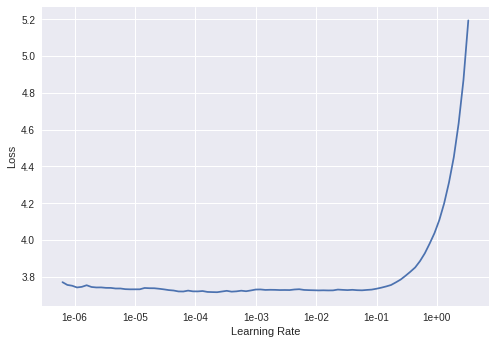

In [21]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2)

In [23]:
learn.save_encoder('ft_enc2')
learn.predict("This is a review about", n_words=10)

'This is a review about how the value of transparency information arises , an understanding'

In [24]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.742954,3.545288,0.356793


In [25]:
learn.predict("This is a review about", n_words=10)

'This is a review about the problem of the \n methods in at the same'

In [26]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,3.737742,3.541556,0.357058


In [0]:
learn.save_encoder('ft_enc3')

In [28]:
learn.predict("This is a review about", n_words=10)

'This is a review about a novel concept on \n mathematical physics , tactile intelligence'

In [29]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.350744,3.257813,0.403861
2,3.205819,3.141952,0.417680
3,3.127597,3.109550,0.422018


In [0]:
learn.save_encoder('ft_enc4')

In [31]:
learn.predict("This is a review about", n_words=10)

'This is a review about the growing growth . < xxup title > xxmaj automated'

In [32]:
learn.predict("This is a review about", n_words=10)

'This is a review about \n the effect of data augmentation resulting from the impact'

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


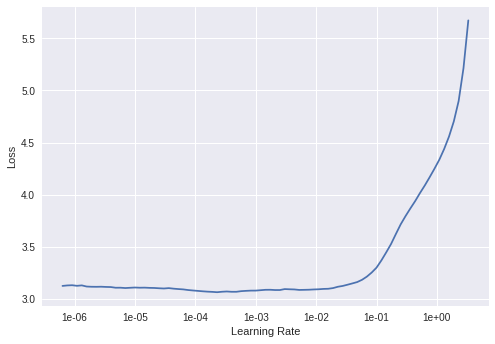

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3, 1e-3)

In [0]:
learn.save_encoder('ft_enc5')

In [44]:
learn.predict("This is a review about", n_words=50)

'This is a review about the two main categories of ours n , namely i ) xxmaj challenge : methodology , approach ) folds : we aim to tier a vast fragility into unreasonable references , window and might benefit from separating creativity and \n parallelism , iii ) teams of a variety of servers'

In [0]:
learn.fit_one_cycle(3, 1e-3)

In [0]:
learn.save_encoder('ft_enc6')

In [0]:
learn.predict("<CAT> csni <SUMM> algorithms that", n_words=50)

In [0]:
learn.predict("<CAT> cscv <SUMM> algorithms that", n_words=10)

In [0]:
learn.predict("<CAT> cscv <SUMM> algorithms. <TITLE> on", n_words=10)

In [0]:
learn.predict("<CAT> csni <SUMM> algorithms. <TITLE> towards ", n_words=10)

In [0]:
learn.predict("<CAT> csni <SUMM> algorithms. <TITLE> towards ", n_words=10)

In [15]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.278474,3.194298,0.412988
2,3.180773,3.126556,0.421394


In [0]:
??learn.fit_one_cycle

In [0]:
learn = language_model_learner(data,
                               emb_sz = 200,   
                               nh = 500,
                               drop_mult=0.5)

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1, 3e-3, wd=1e-6)

epoch,train_loss,valid_loss,accuracy
1,0.004069,7.125626,0.143073


In [0]:
!ls

sample_data


In [0]:
learn.fit_one_cycle(1, 3e-3, wd=1e-6)

epoch,train_loss,valid_loss,accuracy
1,0.004610,7.065801,0.139501


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

TextLMDataBunch;

Train: LabelList
y: LMLabel (0 items)
[]...
Path: /content/drive/My Drive/myfastai/data/arxiv1/all
x: LMTextList (0 items)
[]...
Path: /content/drive/My Drive/myfastai/data/arxiv1/all;

Valid: LabelList
y: LMLabel (0 items)
[]...
Path: /content/drive/My Drive/myfastai/data/arxiv1/all
x: LMTextList (0 items)
[]...
Path: /content/drive/My Drive/myfastai/data/arxiv1/all;

Test: None

In [0]:
learn.save_encoder('ft_enc')
learn.predict("This is a review about", n_words=10)

In [0]:
learn.save_encoder('ft_enc')